In [ ]:
!pip install efficientnet --quiet
!pip install git+https://github.com/qubvel/classification_models.git --quiet
!pip install shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Libraries

In [ ]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

from functools import partial
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam, Adamax, SGD
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.image import ResizeMethod
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
import tensorflow_probability as tfp
import matplotlib.ticker as mticker

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from PIL import Image
from skimage.transform import resize

import keras.backend as K
import numpy as np
import json
import shap

import warnings

import sys
sys.path.append("/content/drive/MyDrive/Articulo (1)/")
import segmentation_models as sm
import tf_mnf
import SegFormer_tf

from utils import *
from reliability_diagrams import *

Segmentation Models: using `tf.keras` framework.
Segmentation Models: using `tf.keras` framework.
Segmentation Models: using `tf.keras` framework.


In [ ]:
import originals as smo
import sm_flip as smflip
from SegFormer_tf.models import SegFormer_B0

In [ ]:
tfp.__version__


'0.23.0'

In [ ]:
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  

In [ ]:
print("Número de GPUs disponibles: ", len(tf.config.list_physical_devices('GPU')))

Número de GPUs disponibles:  1


In [ ]:
# seed
np.random.seed(1234)
tf.random.set_seed(1234)

## Pretraining


In [ ]:
#import argparse
#parser = argparse.ArgumentParser(description = 'Training Par')

# parser.add_argument('-model', '--model',
#                     type = str,
#                     choices = ['FPN','Unet','Linknet'],
#                     default = 'Unet'
#                     )
# parser.add_argument('-bone', '--bone',
#                     type = str,
#                     choices = ['efficientnetb7','seresnet101','densenet169'],
#                     default = 'efficientnetb7'
#                    )
# parser.add_argument('-loss', '--loss',
#                     type = str,
#                     default = 'bce'
#                     )

# args = parser.parse_args()

In [ ]:
# Images
base_dir = '/content/drive/MyDrive/Articulo/CVC - CLINICDB/'
modelos = '/content/drive/MyDrive/Articulo/models_saved/'
imagenes_dir = base_dir + '/PNG/Original'
masks_dir = base_dir + '/PNG/Ground Truth'

In [ ]:
clases = {
    0: [(0, 0, 0), 'background'],
    1: [(255, 255, 255), 'polipo']}

In [ ]:
metadata_df = pd.read_csv(os.path.join(base_dir, 'metadata.csv'))
metadata_df = metadata_df[['frame_id', 'png_image_path', 'png_mask_path']]

In [ ]:
# Directory
metadata_df['png_image_path'] = metadata_df['png_image_path'].apply(lambda x: base_dir + x)
metadata_df['png_mask_path'] = metadata_df['png_mask_path'].apply(lambda x: base_dir + x)

In [ ]:
#Shape
metadata_df.shape

(612, 3)

In [ ]:
#Split Train,Validacion y Test:

train_df, tmp_df = train_test_split(metadata_df[['png_image_path', 'png_mask_path']],  train_size= 0.7, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(tmp_df,  train_size= 0.6, shuffle= False, random_state= 42)

In [ ]:
print(len(train_df),len(test_df),len(valid_df))

428 74 110


In [ ]:
train_df_dict=dict(train_df)
valid_df_dict=dict(valid_df)
test_df_dict=dict(test_df)

In [ ]:
BATCH_SIZE=8

In [ ]:
train_dataset=preprocessing(train_df_dict,train=True)
valid_dataset=preprocessing(valid_df_dict)
test_dataset=preprocessing(test_df_dict)

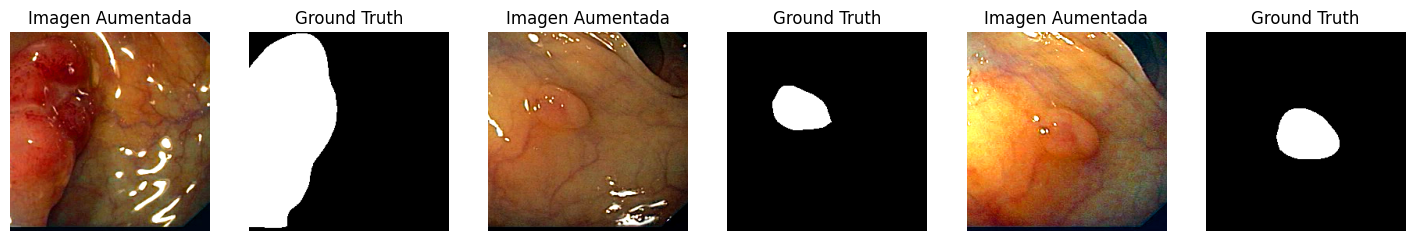

In [ ]:
a=18
fig, ax = plt.subplots(1, 6, figsize=(a, a))

for i, (image, mask) in enumerate(train_dataset.take(3)):
    
    image = image.numpy()
    mask = mask.numpy()

    ax[i*2].imshow(image[0])
    ax[i*2].axis('off')
    ax[i*2].set_title('Imagen Aumentada')

    ax[i*2+1].imshow(mask[0], cmap='gray')
    ax[i*2+1].axis('off')
    ax[i*2+1].set_title('Ground Truth')

In [ ]:
#Binary.
for img, mask in train_dataset.take(1):
  print(np.unique(mask))
  print(mask.shape)

[0. 1.]
(8, 256, 256, 1)


### 4. Segmentation models

In [ ]:
# BinaryIoU: Calcula el coeficiente de intersección sobre unión (IoU) para clases binarias.
iou_metric = tf.keras.metrics.BinaryIoU()
# Precision: Calcula la precisión del modelo.
prec_metric = tf.keras.metrics.Precision()
# Recall: Calcula el recall (sensibilidad) del modelo.
rec_metric = tf.keras.metrics.Recall()
# AUC: Calcula el área bajo la curva (AUC).
roc_metric = tf.keras.metrics.AUC(curve='ROC', name='roc_auc')
# Accuracy: Calcula la precisión del modelo.
acc_metric = tf.keras.metrics.BinaryAccuracy()
FN_metric= tf.keras.metrics.FalseNegatives()
FP_metric= tf.keras.metrics.FalsePositives()

### 5. Models

In [ ]:
#model_Unet=modelos_segmentacion('Unet','bce','efficientnetb7',100, train_dataset=train_dataset, valid_dataset=valid_dataset)

In [ ]:
columnas=['loss','binary_accuracy','binary_io_u','precision','recall','roc_auc','false_negatives','false_positives']

### 6. Iterations and loss funtions

In developing segmentation models, different pre-trained frameworks known as backbones are used. Some examples are EfficientNetB7, SeresNet101 and DenseNet169. These frameworks provide a solid foundation for segmentation models, allowing for more accurate and efficient results. Some of the best performing models include FPN, Unet and Linknet, which we will combine.

In [ ]:
# Modelos

# MODEL=['FPN','Unet','Linknet']

# Backbones: Estructuras pre-entrenadas que se van a utilizar en los modelos de segmentación.

# BACKBONES = ['efficientnetb7','seresnet101','densenet169']

#model=args.model
#loss=args.loss
#BACKBONE=args.bone

#modelos_segmentacion(model, loss, BACKBONE ,epochs=15)

### 7. Bayesian Models

In [ ]:
# Obtener la configuración de la capa `-i` de la red neuronal.
#backbone.layers[-i].get_config()

# Nombres de las capas del FPN clave:
#   - fpn_stage_p2_conv (Conv2D)
#   - segm_stage2a_conv (Conv2D)
#   - segm_stage2b_conv (Conv2D)
#   - top_conv

Prueba con SegFormer:

In [ ]:
 #model_seg=modelos_segmentacion('SegFormer','bce','efficientnetb7',100, train_dataset=train_dataset, valid_dataset=valid_dataset)

Prueba con capas tpf.Conv2dFlipout:

In [ ]:
 #model_FLIP=modelos_segmentacion('FPNFLIP','bnn','efficientnetb7',25, train_dataset=train_dataset, valid_dataset=valid_dataset)

Prueba con capas tpf.Convolution2DReparameterization:

In [ ]:
#model_REP=modelos_segmentacion('FPNREP','bnn','efficientnetb7',11, train_dataset=train_dataset, valid_dataset=valid_dataset)

In [ ]:
#model_UNET_REP=modelos_segmentacion('UNETREP','bnn','efficientnetb7',13, train_dataset=train_dataset, valid_dataset=valid_dataset,test_dataset=test_dataset)

In [ ]:
#model_REP=modelos_segmentacion('LINKREP','bnn','efficientnetb7',13, train_dataset=train_dataset, valid_dataset=valid_dataset,test_dataset=test_dataset)

## Results with FPN

In [ ]:
#model_FPN=modelos_segmentacion('FPN','bnn','efficientnetb7',100, train_dataset=train_dataset, valid_dataset=valid_dataset)

model_FPN = sm.FPN('efficientnetb7', classes=1, activation='sigmoid')
model_FPN.load_weights("/content/drive/MyDrive/Articulo (1)/Modelos_BNN/FPN - 2/checkpoint")

#Modelo Determinista
model_FPN_det = smo.FPN('efficientnetb7', classes=1, activation='sigmoid')
model_FPN_det.load_weights("/content/drive/MyDrive/Articulo (1)/models_saved/model_FPN-efficientnetb7-<segmentation_models.base.objects.SumOfLosses object at 0x7feabc2b67d0>/checkpoint.h5")

In [ ]:
# for j in range(8):
#     imagenes(j,model_FPN,model_FPN_det)

# for j in range(8):
#     imagenes(j,model_FPN,model_FPN_det,test_dataset=valid_dataset)

In [ ]:
test=[(7, 1), (7, 2), (6, 3), (5, 5), (7, 3)]
valid=[(1, 0)]
train=[(1, 1)]

In [ ]:
dataset_seleccionado_test=imagenes_seleccionadas(test,test_dataset)
dataset_seleccionado_valid=imagenes_seleccionadas(valid,valid_dataset)
#dataset_seleccionado_train=imagenes_seleccionadas(train,train_dataset)

In [ ]:
# for i, (img, mask) in enumerate(dataset_seleccionado_valid):
#      print(i)
#      print(img.shape)

In [ ]:
# import importlib
# import utils

# importlib.reload(utils)

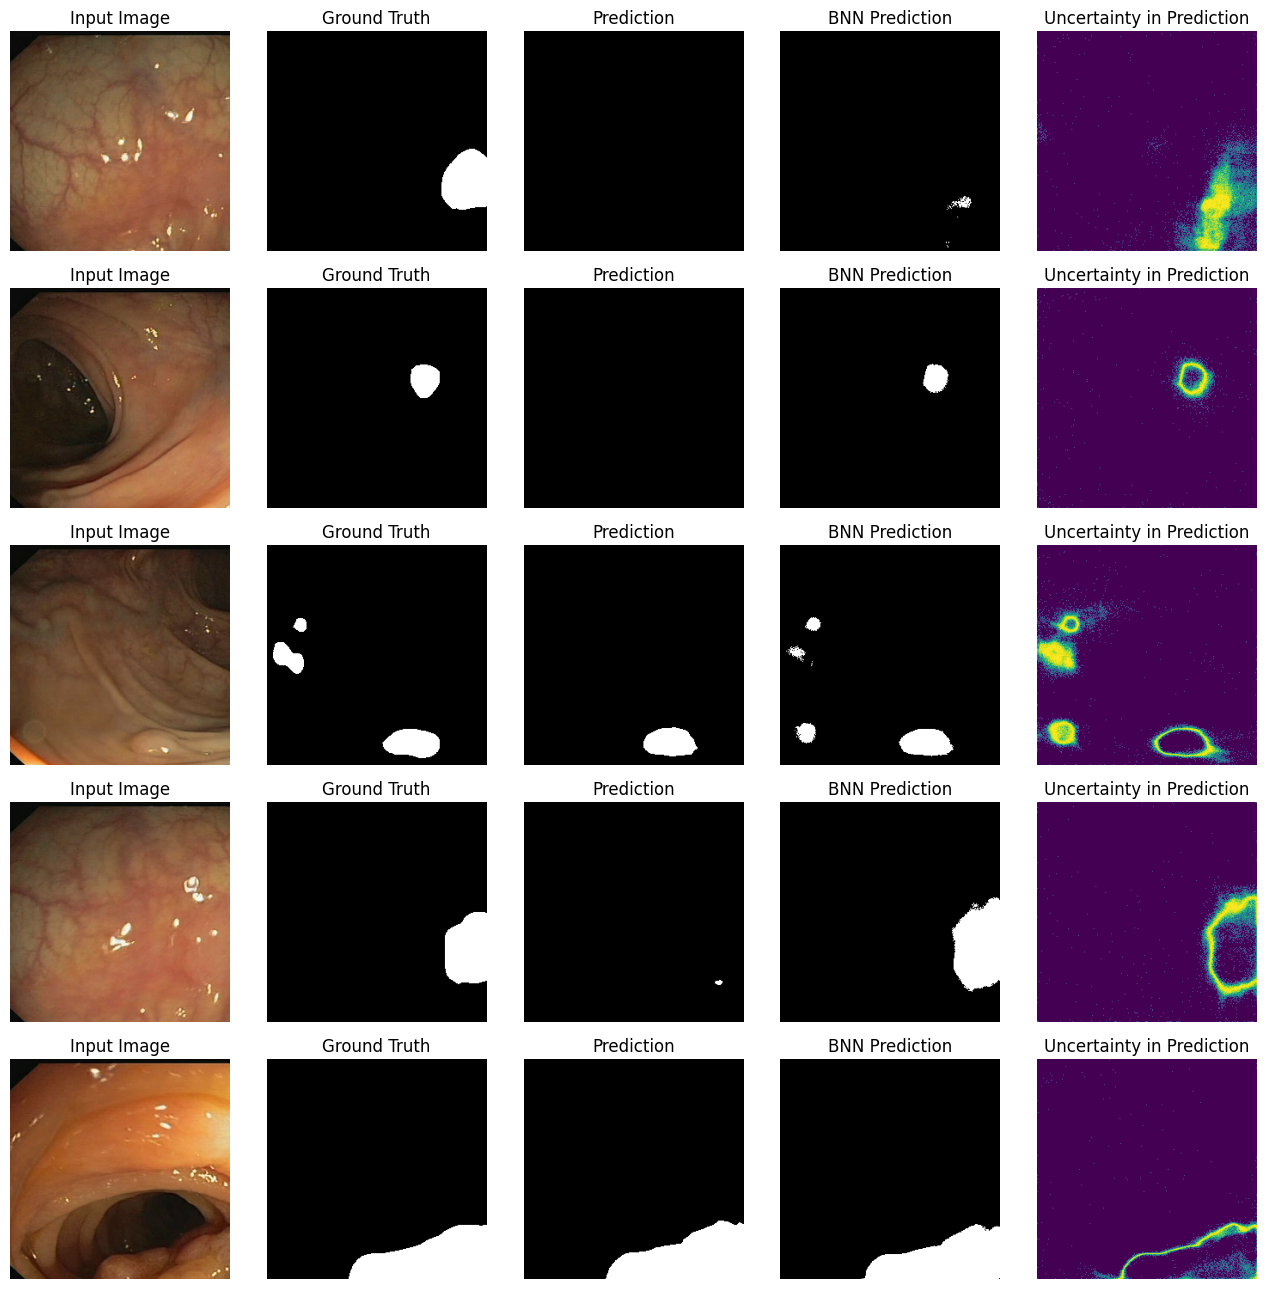

In [ ]:
imagenes(1,model_FPN,model_FPN_det,test_dataset=dataset_seleccionado_test,n=5,unica=1)

## Results with Linknet

In [ ]:
model_link = sm.Linknet('efficientnetb7', classes=1, activation='sigmoid')
model_link.load_weights("/content/drive/MyDrive/Articulo/Modelos_BNN/LINKNET - 3/checkpoint")

#Modelo Determinista
model_linknet_det= smo.Linknet('efficientnetb7', classes=1, activation='sigmoid')
model_linknet_det.load_weights("/content/drive/MyDrive/Articulo/models_saved/model_Linknet-efficientnetb7-<keras.losses.BinaryCrossentropy object at 0x7fd9cc156740>/checkpoint.h5")

In [ ]:
# for i, (img, mask) in enumerate(valid_dataset):
#   print(i)
#   print(img.shape)

In [ ]:
#imagenes(1,model_link,model_linknet_det,test_dataset=dataset_seleccionado_test,n=4,unica=1)

## Results with UNET

In [ ]:
#model_3=modelos_segmentacion('Unet','bnn','efficientnetb7',100, train_dataset=train_dataset, valid_dataset=valid_dataset)

model_unet = sm.Unet('efficientnetb7', classes=1, activation='sigmoid')
model_unet.load_weights("/content/drive/MyDrive/Articulo/Modelos_BNN/UNET - 1/checkpoint")

#Modelo Determinista
model_unet_det = smo.Unet('efficientnetb7', classes=1, activation='sigmoid')
model_unet_det.load_weights("/content/drive/MyDrive/Articulo/models_saved/model_Unet-efficientnetb7-<keras.losses.BinaryCrossentropy object at 0x7fa5f190ecb0>/checkpoint.h5")

In [ ]:
#imagenes(1,model_unet,model_unet_det,test_dataset=dataset_seleccionado_test,n=4,unica=1)

## Results with tpf.Flipout layers


In [ ]:
# # #FPNFLIP

# model_FPN_flip = smflip.FPN('efficientnetb7', classes=1, activation='sigmoid')
# model_FPN_flip.load_weights("/content/drive/MyDrive/Articulo/Modelos_BNN/FPNFLIP - 2/checkpoint")

In [ ]:
#model_FPN_flip.summary()

In [ ]:
#imagenes(1,model_FPN_flip,model_FPN_det,test_dataset=dataset_seleccionado_test,n=2,unica=1)

## Results with tpf.reparametrizacion layers

In [ ]:
#LINKREP

model_Link_rep = smflip.Linknet('efficientnetb7', classes=1, activation='sigmoid')
model_Link_rep.load_weights("/content/drive/MyDrive/Articulo/Modelos_BNN/LINKREP - 3/checkpoint")

In [ ]:
#imagenes(1,model_Link_rep,model_linknet_det,test_dataset=dataset_seleccionado_test,n=4,unica=1)

In [ ]:
#UNETREP

model_Unet_rep = smflip.Unet('efficientnetb7', classes=1, activation='sigmoid')
model_Unet_rep.load_weights("/content/drive/MyDrive/Articulo/Modelos_BNN/UNETREP - 1/checkpoint")

In [ ]:
#imagenes(1,model_Unet_rep,model_unet_det,test_dataset=dataset_seleccionado_test,n=4,unica=1)

In [ ]:
#FPNREP

model_FPN_rep = smflip.FPN('efficientnetb7', classes=1, activation='sigmoid')
model_FPN_rep.load_weights("/content/drive/MyDrive/Articulo/Modelos_BNN/FPNREP - 2/checkpoint")

In [ ]:
#  model_FPN_rep.compile(
#         loss=lambda x, prob:-prob.log_prob(x),
#         optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
#         metrics=[acc_metric,iou_metric,prec_metric,rec_metric,roc_metric,FN_metric,FP_metric]
#     )
# model_FPN_rep.evaluate(test_dataset)

In [ ]:
#imagenes(1,model_FPN_rep,model_FPN_det,test_dataset=dataset_seleccionado_test,n=4,unica=1)

## Feature Importance:

In [ ]:
from tensorflow.keras import backend as K
import numpy as np
import json
import shap
from efficientnet.model import EfficientNetB7, preprocess_input

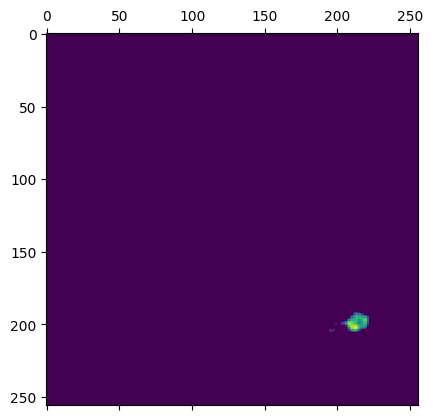

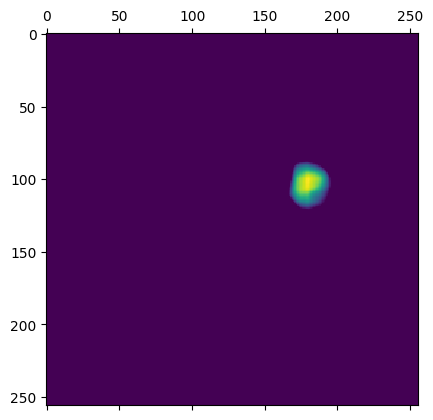

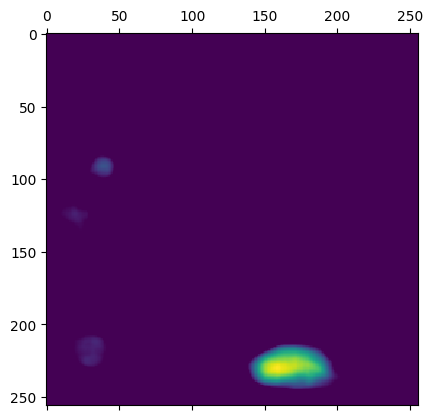

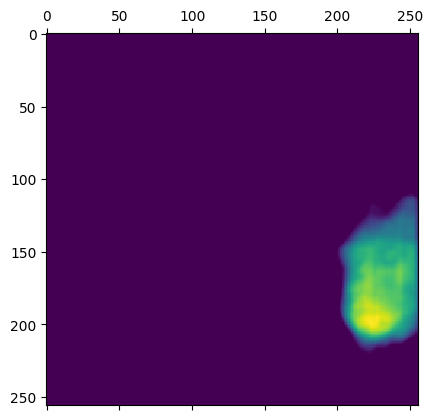

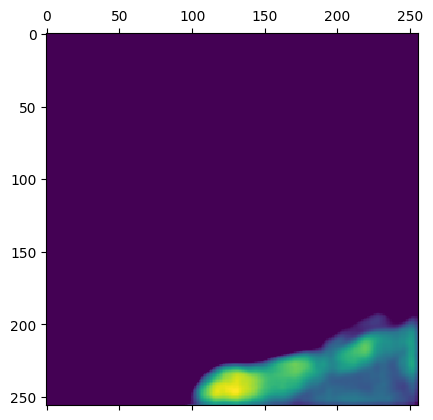

In [ ]:
model=model_FPN

for i, (img, mask) in enumerate(dataset_seleccionado_test):
    X, y = img, mask
    X = tf.expand_dims(X, axis=0)

    last_conv_layer = model.get_layer('head_conv')
    last_conv_layer_model = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = last_conv_layer_model(X)
        predictions = tf.reshape(predictions, (predictions.shape[0], -1, predictions.shape[-1]))

        top_class_channel = tf.reduce_sum(predictions, axis=[1])

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    plt.matshow(heatmap)
    plt.show()

  #media y ds sobre una misma imagen 40-50 iteraciones. (gradientes)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

model = model_FPN

# Inicializa una lista para almacenar los mapas de calor promediados
average_heatmaps = []

for i, (img, mask) in enumerate(dataset_seleccionado_test):
    X, y = img, mask
    X = tf.expand_dims(X, axis=0)

    last_conv_layer = model.get_layer('head_conv')
    last_conv_layer_model = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])

    # Inicializa una lista para almacenar los gradientes de cada predicción
    grads_list = []

    # Repite el proceso de predicción y cálculo de gradientes 50 veces
    for j in range(2):
        with tf.GradientTape() as tape:
            last_conv_layer_output, predictions = last_conv_layer_model(X)
            predictions = tf.reshape(predictions, (predictions.shape[0], -1, predictions.shape[-1]))
            top_class_channel = tf.reduce_sum(predictions, axis=[1])

        # Calcula los gradientes con respecto a la salida activada de la última capa convolucional
        grads = tape.gradient(top_class_channel, last_conv_layer_output)

        # Almacena los gradientes en la lista
        grads_list.append(grads)

    # Calcula el promedio de los gradientes usando TensorFlow
    averaged_grads = tf.reduce_mean(tf.stack(grads_list), axis=0)
    grads_stddev = tf.math.reduce_std(grads_tensor, axis=0)
    grads_stddev = tf.cast(grads_stddev, tf.float64)

    # Pooled gradients (promedio de los gradientes por canal)
    pooled_grads = tf.reduce_mean(averaged_grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Heatmap post-processing
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Almacena el heatmap promediado en la lista
    average_heatmaps.append(heatmap)

# Visualiza los heatmaps promediados
for heatmap in average_heatmaps:
    plt.matshow(heatmap)
    plt.show()

NameError: name 'grads_tensor' is not defined

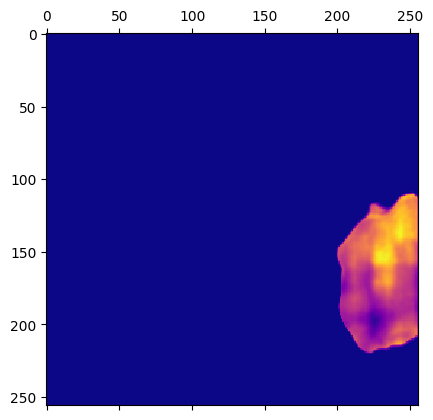

In [ ]:
model=model_FPN
i=50
grads_all = []
img, mask = next(iter(dataset_seleccionado_test.skip(3))) # Obtén la primera imagen y su máscara
heatmap_shape = (img.shape[0], img.shape[1]) # Asume que los mapas de calor son de 2D
heatmaps_all = np.zeros((i,) + heatmap_shape) #  # Inicializa el array para almacenar los mapas de calor

for iteration in range(i):
    X, y = img, mask
    X = tf.expand_dims(X, axis=0)

    last_conv_layer = model.get_layer('head_conv')
    last_conv_layer_model = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = last_conv_layer_model(X)
        predictions = tf.reshape(predictions, (predictions.shape[0], -1, predictions.shape[-1]))
        top_class_channel = tf.reduce_sum(predictions, axis=[1])

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    grads_all.append(grads.numpy())

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmaps_all[iteration, :, :] = heatmap.numpy() # Guarda el mapa de calor en lugar de mostrarlo

# Cálculo del mapa de calor de las desviaciones estándar
heatmap_std = heatmaps_all.std(axis=0)
plt.matshow(heatmap_std, cmap='plasma')
plt.show()

In [ ]:
# model = model_FPN

# # Inicializa listas para almacenar los mapas de calor promedio y desviación estándar
# average_heatmaps = []
# stddev_heatmaps = []

# for i, (img, mask) in enumerate(dataset_seleccionado_test):
#     X, y = img, mask
#     X = tf.expand_dims(X, axis=0)

#     last_conv_layer = model.get_layer('head_conv')
#     last_conv_layer_model = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])

#     # Inicializa listas para almacenar los gradientes y predicciones de cada iteración
#     grads_list = []
#     predictions_list = []

#     # Repite el proceso de predicción y cálculo de gradientes 50 veces
#     for j in range(10):  # Usar rango(50) para hacer 50 iteraciones
#         with tf.GradientTape() as tape:
#             last_conv_layer_output, predictions = last_conv_layer_model(X)
#             predictions = tf.reshape(predictions, (predictions.shape[0], -1, predictions.shape[-1]))
#             top_class_channel = tf.reduce_sum(predictions, axis=[1])

#         grads = tape.gradient(top_class_channel, last_conv_layer_output)
#         grads_list.append(grads)
#         predictions_list.append(predictions)

#     # Calcula el promedio y la desviación estándar de los gradientes
#     grads_tensor = tf.stack(grads_list)
#     averaged_grads = tf.reduce_mean(grads_tensor, axis=0)
#     grads_stddev = tf.math.reduce_std(grads_tensor, axis=0)

#     # Calcula el promedio y la desviación estándar de las predicciones
#     predictions_tensor = tf.stack(predictions_list)
#     predictions_stddev = tf.math.reduce_std(predictions_tensor, axis=0)

#     # Pooled gradients (promedio de los gradientes por canal)
#     pooled_grads = tf.reduce_mean(averaged_grads, axis=(0, 1, 2))
#     pooled_predictions_stddev = tf.reduce_mean(predictions_stddev, axis=(1, 2))

#     # Crea los heatmaps
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap_avg = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap_avg = tf.squeeze(heatmap_avg)
#     heatmap_stddev = last_conv_layer_output @ pooled_predictions_stddev[..., tf.newaxis]
#     heatmap_stddev = tf.squeeze(heatmap_stddev)

#     # Post-procesamiento de los heatmaps
#     heatmap_avg = tf.maximum(heatmap_avg, 0) / tf.math.reduce_max(heatmap_avg)
#     heatmap_stddev = tf.maximum(heatmap_stddev, 0) / tf.math.reduce_max(heatmap_stddev)

#     # Almacena los heatmaps promedio y de desviación estándar
#     average_heatmaps.append(heatmap_avg)
#     stddev_heatmaps.append(heatmap_stddev)

# # Visualiza los heatmaps promedio y de desviación estándar
# for heatmap_avg, heatmap_stddev in zip(average_heatmaps, stddev_heatmaps):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     axs[0].imshow(heatmap_avg, cmap='viridis')
#     axs[0].axis('off')
#     axs[0].set_title('Average Heatmap')

#     axs[1].imshow(heatmap_stddev, cmap='viridis')
#     axs[1].axis('off')
#     axs[1].set_title('Std Dev Heatmap')
#     plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

model = model_FPN

# Inicializa listas para almacenar los mapas de calor promedio y de desviaciones estándar
average_heatmaps = []
stddev_heatmaps = []  # Agregar lista para los mapas de calor de desviación estándar

for i, (img, mask) in enumerate(dataset_seleccionado_test):
    X, y = img, mask
    X = tf.expand_dims(X, axis=0)

    last_conv_layer = model.get_layer('head_conv')
    last_conv_layer_model = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])

    # Inicializa listas para almacenar los gradientes y predicciones de cada iteración
    grads_list = []
    predictions_list = []

    # Repite el proceso de predicción y cálculo de gradientes varias veces
    for j in range(5):  # Cambiar a 50 iteraciones para el cálculo final
        with tf.GradientTape() as tape:
            last_conv_layer_output, predictions = last_conv_layer_model(X)
            predictions = tf.reshape(predictions, (predictions.shape[0], -1, predictions.shape[-1]))
            top_class_channel = tf.reduce_sum(predictions, axis=[1])

        grads = tape.gradient(top_class_channel, last_conv_layer_output)
        grads_list.append(grads)
        predictions_list.append(predictions)

    # Calcula el promedio y la desviación estándar de los gradientes
    grads_tensor = tf.stack(grads_list)
    averaged_grads = tf.reduce_mean(grads_tensor, axis=0)
    grads_stddev = tf.math.reduce_std(grads_tensor, axis=0)

    # Calcula la desviación estándar de las predicciones
    predictions_tensor = tf.stack(predictions_list)
    predictions_stddev = tf.math.reduce_std(predictions_tensor, axis=0)

    # Pooled gradients y pooled standard deviation
    pooled_grads = tf.reduce_mean(averaged_grads, axis=(0, 1, 2))
    pooled_stddev = tf.math.reduce_std(predictions_tensor, axis=(0,1,2))

    # Genera los heatmaps para la media
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap_avg = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap_avg = tf.squeeze(heatmap_avg)

    # Genera los heatmaps para la desviación estándar usando pooled standard deviation
    heatmap_stddev = last_conv_layer_output @ pooled_stddev[..., tf.newaxis]
    heatmap_stddev = tf.squeeze(heatmap_stddev)

    # Normaliza los heatmaps
    heatmap_avg = tf.maximum(heatmap_avg, 0) / tf.math.reduce_max(heatmap_avg)
    heatmap_stddev = tf.maximum(heatmap_stddev, 0) / tf.math.reduce_max(heatmap_stddev)

    # Almacena los heatmaps
    average_heatmaps.append(heatmap_avg)
    stddev_heatmaps.append(heatmap_stddev)

# Visualiza los heatmaps promedio y de desviación estándar
for heatmap_avg, heatmap_stddev in zip(average_heatmaps, stddev_heatmaps):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(heatmap_avg, cmap='viridis')
    axs[0].axis('off')
    axs[0].set_title('Average Heatmap')

    axs[1].imshow(heatmap_stddev, cmap='viridis')
    axs[1].axis('off')
    axs[1].set_title('Standard Deviation Heatmap')

    plt.show()

In [ ]:

# # load pre-trained model and choose two images to explain
# for i, (img, mask) in enumerate(dataset_seleccionado_valid):
#     X, y = img, mask
#     to_explain = X
#     model = model_FPN_det

#     # explain how the input to the 7th layer of the model explains the top two classes
#     def map2layer(x, layer):
#         x = x.numpy() if hasattr(x, 'numpy') else x
#         x = np.expand_dims(x, axis=0)
#         submodel = tf.keras.models.Model(inputs=model.inputs, outputs=model.get_layer(index=layer).output)
#         return submodel.predict(x / 127.5 - 1)

#     print(model.layers[-1].output[:,0])

#     e = shap.GradientExplainer(
#         (model.layers[-80].input,model.layers[-1].output),
#         map2layer(X, -80),
#         local_smoothing=0)


#     # # Antes de llamar a la función e.shap_values.
#     # map2layer_values = map2layer(to_explain, -80)

#     # # Get the input shape of your model, skipping the batch size dimension
#     # input_shape = model_flattened.input_shape[1:]

#     # print(map2layer_values.shape)
#     # print(input_shape)

#     # reshaped_map2layer_values = np.reshape(map2layer_values, (-1,) + input_shape)
#     # shap_values, indexes = e.shap_values(reshaped_map2layer_values, ranked_outputs=2)

#     # # get the names for the classes
#     # index_names = [0, 1]

#     # # plot the explanations
#     # shap.image_plot(shap_values, to_explain, index_names)

## Calibracion:

Para realizar los cálculos de calibración, necesitamos tener acceso a tres elementos: el resultado de salida del modelo (para calcular el promedio de las probabilidades por categoría), las etiquetas predichas y las etiquetas reales (para calcular accuracy).

La fórmula del ECE:

$
ECE = \frac{1}{M} \sum_{m=1}^{M} |B_M| |acc(B_M) - conf(B_M)|
$

donde M es el número total de muestras o pixeles, $acc(B_M)$ es el acc promedio de las predicciones en el bin m y confidence es la probabilidad promedio de las predicciones en el bin m.

In [ ]:
#Se extraen (img,mask) del conjunto de datos y se convierten a arrays de numpy.
#Logits (confidence / lo que sale del modelo) se guarda en output.

def test(model):
    logits = []
    labels = []
    predicted = []
    for i, (img, mask) in enumerate(test_dataset):
        img, mask = img.numpy(), mask.numpy()

        #Calculamos los logits
        output = model(img)
        #output = tf.nn.sigmoid(output).numpy()

        #pred = model.predict(img,verbose=0)
        predictions = tf.nn.sigmoid(output).numpy()
        predictions_det = np.where(predictions > 0.5, 1, 0)

        #Añadimos a la lista
        logits.append(output)
        labels.append(mask.astype('int64'))
        predicted.append(predictions_det)

    return tf.concat(logits, axis=0), tf.concat(labels, axis=0), tf.concat(predicted, axis=0)

In [ ]:
def flatten(model,bins=15):
  logits, labels , preds = test(model)

  logits_flat = tf.expand_dims(np.ravel(logits),axis=0)
  labels_flat = tf.expand_dims(np.ravel(labels),axis=0)
  preds_flat = tf.expand_dims(np.ravel(preds),axis=0)

  #ece=tfp.stats.expected_calibration_error(bins, logits=logits_flat, labels_true=labels_flat, labels_predicted=preds_flat)
  return(logits_flat, labels_flat , preds_flat)

In [ ]:
# lista=['UNET','LINKNET','FPN','FPN-Rep','UNET-Rep','Link-Rep']

# for i,model in enumerate([model_unet,model_link,model_FPN,model_FPN_rep]):
#     logits_flat, labels_flat, preds_flat, ece = evaluate_cal_ece(model)
#     print(lista[i],':',f'{ece}')

Definimos las funciones para calcular ECE y UCE (con un enfoque de imagenes) y plots de calibracion:

In [ ]:
def _calculate_ece(logits,labels,preds,n_bins=15):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidences = tf.nn.sigmoid(logits).numpy()
    predictions=preds
    accuracies = np.equal(predictions,labels)

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = in_bin.astype(float).mean()
        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].astype(float).mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

In [ ]:
lista=['UNET-MNF','LINKNET-MNF','FPN-MFN','FPN-REP','UNET-REP','LINK-REP']

for i,model in enumerate([model_unet,model_link,model_FPN,model_FPN_rep,model_Unet_rep,model_Link_rep]):
    logits_flat, labels_flat, preds_flat = flatten(model)
    print(lista[i],':',_calculate_ece(logits_flat,labels_flat,preds_flat))

In [ ]:
def make_model_diagrams(logits,labels, preds, n_bins=15, modelo='Unet'):
#Documentar y pasar a utils
    """
    outputs - a tensorflow tensor (size n x num_classes) with the outputs from the final linear layer
    - NOT the softmaxes
    labels - a tensorflow tensor (size n) with the labels
    """
    logits = np.ravel(logits)
    labels = np.ravel(labels)
    preds =  np.ravel(preds)

    confidences = tf.nn.sigmoid(logits).numpy()
    accuracies = np.equal(labels,preds).astype(int)  # 1 1 1 1 1 1 1 1
    overall_accuracy = (labels==preds).sum()/len(labels) #0.9891

    # Reliability diagram
    bins = np.linspace(0, 1, n_bins + 1)
    width = 1.0 / n_bins
    bin_centers = np.linspace(0, 1.0 - width, n_bins) + width / 2
    lefts = bins[:-1]
    rights = bins[1:]
    bin_sizes = np.zeros(n_bins)
    p_true = np.zeros(n_bins)
    p_pred = np.zeros(n_bins)

    for bin_num in range(n_bins):
        ids = (confidences >= lefts[bin_num]) & (confidences < rights[bin_num])
        bin_sizes[bin_num] = np.sum(ids)

        if bin_sizes[bin_num] == 0:
            p_true[bin_num] = 0
            p_pred[bin_num] = (lefts[bin_num] + rights[bin_num]) / 2
        else:
            p_true[bin_num] = np.sum(labels[ids]) / bin_sizes[bin_num]
            p_pred[bin_num] = np.mean(confidences[ids])

    pos = (lefts + rights) / 2

    ece = np.sum(bin_sizes * np.abs(p_true - p_pred)) / np.sum(bin_sizes)

    #Si cumple la condicion el pixel queda dentro del bin

    # bin_indices = [(confidences > bin_lower) & (confidences <= bin_upper) for bin_lower, bin_upper in zip(bins[:-1], bins[1:])]
    # bin_sizes = np.array([np.sum(bin_indices) for bin_index in bin_indices])
    # bin_corrects = np.array([accuracies[bin_index].mean()/bin_sizes[bin_index] for bin_index in bin_indices])
    # print(bin_corrects)
    # bin_scores = np.array([confidences[bin_index].mean() for bin_index in bin_indices])
    # print(bin_scores)
    #bin_corrects = np.nan_to_num(bin_corrects)
    #bin_scores = np.nan_to_num(bin_scores)

    plt.figure(0, figsize=(4, 4))
    gap = np.array(pos - p_pred)

    confs = plt.bar(bin_centers, p_pred, color=[0, 0, 1], width=width, ec='black')
    #bin_corrects = np.nan_to_num(np.array([bin_correct for bin_correct in bin_corrects]))
    gaps = plt.bar(bin_centers, gap, bottom=p_pred, color=[1, 0.7, 0.7], alpha=0.5, width=width, hatch='//', edgecolor='r')

    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.legend([confs, gaps], ['Accuracy', 'Gap'], loc='upper right', fontsize='large',bbox_to_anchor = (1.5,1))

    #ece = _calculate_ece(logits, labels, preds)

    # Clean up
    bbox_props = dict(boxstyle="square", fc="lightgrey", ec="gray", lw=1.5)
    plt.text(0.6, 0.05, "ECE: {:.4f}".format(ece), horizontalalignment='left',
        verticalalignment='bottom', size=13, weight='normal', bbox=bbox_props)

    plt.title(f'{modelo}', size=15)
    plt.ylabel("Accuracy", size=12)
    plt.xlabel("Confidence", size=12)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.savefig(f'{modelo}.png')
    plt.show()
    return None

In [ ]:
#T=[1.9,1.9,1.5,1.4,1.4,1]

lista=['UNET-MNF','LINKNET-MNF','FPN-MNF','FPN-REP','UNET-REP','LINK-REP']

for i, model in enumerate([model_unet, model_link, model_FPN, model_FPN_rep, model_Unet_rep, model_Link_rep]):
    logits, labels, preds = test(model)
    make_model_diagrams(logits, labels, preds, n_bins=15, modelo=lista[i])

In [ ]:
colors = plt.get_cmap("Set1")
lista=['UNET','LINKNET','FPN','FPN-Rep','Unet-Rep','Link-Rep']

#T=[1.9,1.9,1.5,1.4,1.39,1]

for i, model in enumerate([model_unet,model_link,model_FPN,model_FPN_rep,model_Unet_rep,model_Link_rep]):
    plt.figure(figsize=(2, 2))
    logits_flat, labels_flat, preds_flat = flatten(model)
    disp = CalibrationDisplay.from_predictions(np.ravel(labels_flat), np.ravel(tf.nn.sigmoid(logits_flat)), n_bins=15, color=colors(i))
    plt.title(f'Calibracion - {lista[i]}', size=15)
plt.legend()
plt.show()

## Prueba de Calibracion - 2

In [ ]:
def calib_curve(probs, labels, n_bins=15):
    bins = np.linspace(0, 1, n_bins + 1)
    lefts = bins[:-1]
    rights = bins[1:]
    bin_sizes = np.zeros(n_bins)
    p_true = np.zeros(n_bins)
    p_pred = np.zeros(n_bins)
    for bin_num in range(n_bins):
        ids = (probs >= lefts[bin_num]) & (probs < rights[bin_num])
        bin_sizes[bin_num] = np.sum(ids)
        if bin_sizes[bin_num] == 0:
            p_true[bin_num] = 0
            p_pred[bin_num] = (lefts[bin_num] + rights[bin_num]) / 2
        else:
            p_true[bin_num] = np.sum(labels[ids]) / bin_sizes[bin_num]
            p_pred[bin_num] = np.mean(probs[ids])

    pos = (lefts + rights) / 2

    ece = np.sum(bin_sizes * np.abs(p_true - p_pred)) / np.sum(bin_sizes)
    acc = np.sum(np.equal(probs > 0.5, labels)) / len(labels)
    mce = np.max(np.abs(p_true - p_pred))

    return p_true, p_pred, ece, acc, mce, pos

In [ ]:
for i,model in enumerate([model_unet,model_link,model_FPN,model_FPN_rep,model_Unet_rep,model_Link_rep]):
    logits_flat, labels_flat, preds_flat = flatten(model)
    calib = calib_curve(tf.nn.sigmoid(logits_flat),labels_flat, n_bins=15)

    DATA_GRAPH = pd.DataFrame({'CONF':calib[5],'ACC':calib[1]})
    print(DATA_GRAPH)
    DATA_GRAPH['TO_ACC'] = abs(DATA_GRAPH['CONF']-DATA_GRAPH['ACC'])
    MO = []
    B_Un = []
    B_Ov = []
    for row in DATA_GRAPH.index:
      if DATA_GRAPH['CONF'][row] > DATA_GRAPH['ACC'][row]:
        MO.append(DATA_GRAPH['ACC'][row])
        B_Un.append(abs(DATA_GRAPH['CONF'][row] - DATA_GRAPH['ACC'][row]))
        B_Ov.append(0)
      else:
        MO.append(DATA_GRAPH['CONF'][row])
        B_Un.append(0)
        B_Ov.append(abs(DATA_GRAPH['CONF'][row] - DATA_GRAPH['ACC'][row]))

    DATA_GRAPH['BOTTOM_UNDER'] = B_Un
    DATA_GRAPH['BOTTOM_OVER'] = B_Ov

    DATA_GRAPH['MODEL_OUT'] = MO


    DATA_GRAPH = round(DATA_GRAPH, 2)
    DATA_GRAPH

    fig, ax = plt.subplots()

    ax.bar(list(map(str, DATA_GRAPH['CONF'])), DATA_GRAPH['MODEL_OUT'], width=1, edgecolor='black', label='Model Ouput', color='#AAA662')
    ax.bar(list(map(str, DATA_GRAPH['CONF'])),DATA_GRAPH['BOTTOM_UNDER'], bottom=DATA_GRAPH['MODEL_OUT'], width=1, edgecolor='black', label='Under Confident', color='#FFFFCB')
    ax.bar(list(map(str, DATA_GRAPH['CONF'])),DATA_GRAPH['BOTTOM_OVER'], bottom=DATA_GRAPH['MODEL_OUT'], width=1, edgecolor='black', label='Over Confident', color='#650021')

    ax.plot(list(map(str, DATA_GRAPH['CONF'])), DATA_GRAPH['CONF'], color = 'black', linestyle='--', label = 'Perfect Calibration', marker = 'o')
    lista=['UNET','LINKNET','FPN','FPN-Rep','Unet-Rep','Link-Rep']
    ax.set_title('ECE Diagram for {} Model with ECE = {}'.format(lista[i],round(calib[2],4)))
    ax.legend()
    plt.show()

In [ ]:
def expected_calibration_error(samples, true_labels, M=15):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = np.max(samples, axis=1)

    # get predictions from confidences (positional in this case)
    predicted_label = np.argmax(samples, axis=1)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece = np.zeros(1)
    bin_list = []
    bin_prob = []
    acc_bin = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
      # determine if sample is in bin m (between bin lower & upper)
      in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
      # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
      prob_in_bin = in_bin.mean()
      bin_prob.append(prob_in_bin)

      if prob_in_bin.item() > 0:
        # get the accuracy of bin m: acc(Bm)
        accuracy_in_bin = accuracies[in_bin].mean()
        acc_bin.append(accuracy_in_bin)
        # get the average confidence of bin m: conf(Bm)
        avg_confidence_in_bin = confidences[in_bin].mean()
        # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
      else:
        acc_bin.append(0)

      bin_list.append(round((bin_lower+(bin_upper - bin_lower)/2),2))

    return ece, bin_prob, acc_bin, bin_list

### Codigos para calibracion - Adicionales

In [ ]:
# bin_indices = [tf.logical_and(confidences >= tf.cast(bin_lower,tf.float32), confidences < tf.cast(bin_upper,tf.float32)) for bin_lower, bin_upper in zip(bins[:-1], bins[1:])]
# bin_corrects = np.array([tf.reduce_mean(tf.boolean_mask(tf.cast(accuracies,tf.float32), bin_index)).numpy() for bin_index in bin_indices])
# bin_scores = np.array([tf.reduce_mean(tf.boolean_mask(tf.cast(confidences, tf.float32), bin_index)).numpy() for bin_index in bin_indices])
# bin_corrects = np.nan_to_num(bin_corrects)
# bin_scores = np.nan_to_num(bin_scores)


In [ ]:
# softmaxes=tf.nn.sigmoid(logits_flat)
# confidences = tf.reduce_max(softmaxes, 1)
# accuracies = tf.math.equal(preds_flat, labels_flat)
# predictions = tf.argmax(softmaxes, 1)

In [ ]:
# errors = tf.math.not_equal(predictions, labels)
# uncertainties = nentr(softmaxes, base=tf.shape(softmaxes)[1])

# num_bins = 15  # Puedes ajustar el número de intervalos según tus necesidades
# bin_size = 1 / num_bins

# bin_edges = np.arange(0, 1 + bin_size, bin_size)
# bin_indices = np.digitize(confidences, bin_edges)

# bin_accuracies = []
# for i in range(1, num_bins + 1):
#     bin_mask = bin_indices == i
#     bin_accuracies.append(np.mean(accuracies[bin_mask]))

Funciones ECE UCE:

In [ ]:
# def eceloss(logits, labels, n_bins=15):
#     softmaxes=tf.nn.sigmoid(logits)
#     bin_boundaries = tf.linspace(0, 1, n_bins + 1)
#     bin_lowers = bin_boundaries[:-1]
#     bin_uppers = bin_boundaries[1:]

#     confidences = tf.reduce_max(softmaxes, 1)
#     predictions = tf.argmax(softmaxes, 1)
#     accuracies = tf.math.equal(predictions, labels)
#     accuracy_in_bin_list = []
#     avg_confidence_in_bin_list = []

#     ece = tf.constant([0.0])
#     for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
#         in_bin = tf.math.logical_and(tf.math.greater(confidences, bin_lower.numpy()),
#                                      tf.math.less_equal(confidences, bin_upper.numpy()))
#         prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))
#         if prop_in_bin.numpy() > 0.0:
#             accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
#             avg_confidence_in_bin = tf.reduce_mean(confidences[in_bin])
#             ece += tf.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

#             accuracy_in_bin_list.append(accuracy_in_bin)
#             avg_confidence_in_bin_list.append(avg_confidence_in_bin)

#     acc_in_bin = tf.constant(accuracy_in_bin_list)
#     avg_conf_in_bin = tf.constant(avg_confidence_in_bin_list)

#     return ece, acc_in_bin, avg_conf_in_bin

In [ ]:
# def nentr(p, base=None):
#     """
#     Calculates entropy of p to the base b. If base is None, the natural logarithm is used.
#     :param p: batches of class label probability distributions (softmax output)
#     :param base: base b
#     :return:
#     """
#     eps = tf.constant([1e-16], dtype=p.dtype)
#     if base:
#         base = tf.constant([base], dtype=p.dtype)
#         return tf.reduce_sum(
#             tf.abs(tf.multiply(p, tf.divide(tf.math.log(tf.add(p, eps)), tf.math.log(base)))),axis=1)
#     else:
#         return tf.reduce_sum(tf.abs(tf.multiply(p, tf.math.log(tf.add(p, eps)))), axis=1,)

In [ ]:
# def uceloss(logits, labels, n_bins=15):
#     softmaxes=tf.nn.sigmoid(logits)
#     bin_boundaries = tf.linspace(0, 1, n_bins + 1)
#     bin_lowers = bin_boundaries[:-1]
#     bin_uppers = bin_boundaries[1:]

#     predictions = tf.argmax(softmaxes, 1)
#     errors = tf.math.not_equal(predictions, labels)
#     uncertainties = nentr(softmaxes, base=tf.shape(softmaxes)[1])  # nentr needs to be implemented
#     errors_in_bin_list = []
#     avg_entropy_in_bin_list = []

#     uce = tf.constant([0.0])
#     for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
#         # Calculate |uncert - err| in each bin
#         in_bin = tf.math.logical_and(tf.math.greater(uncertainties, bin_lower.numpy()),
#                                      tf.math.less_equal(uncertainties, bin_upper.numpy()))
#         prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))
#         if prop_in_bin.numpy() > 0.0:
#             errors_in_bin = tf.reduce_mean(tf.cast(errors[in_bin], tf.float32))
#             avg_entropy_in_bin = tf.reduce_mean(uncertainties[in_bin])
#             uce += tf.abs(avg_entropy_in_bin - errors_in_bin) * prop_in_bin

#             errors_in_bin_list.append(errors_in_bin)
#             avg_entropy_in_bin_list.append(avg_entropy_in_bin)

#     err_in_bin = tf.constant(errors_in_bin_list)
#     avg_entropy_in_bin = tf.constant(avg_entropy_in_bin_list)

#     return uce, err_in_bin, avg_entropy_in_bin

In [ ]:
#eceloss(logits_flat, labels_flat, n_bins=15)

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.plot(bin_edges[:-1], bin_accuracies, marker='o')
# plt.plot([0,1], [0,1], 'k--')
# plt.xlabel("Confidence")
# plt.ylabel("Accuracy")
# plt.title("Reliability Diagram")
# plt.show()

# def plot_conf(acc, conf):
#     fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25))
#     ax.plot([0,1], [0,1], 'k--')
#     ax.plot(conf, acc, marker='.')
#     ax.set_xlabel(r'confidence')
#     ax.set_ylabel(r'accuracy')
#     ax.set_xticks((np.arange(0, 1.1, step=0.2)))
#     ax.set_yticks((np.arange(0, 1.1, step=0.2)))

#     return fig, ax

# def plot_uncert(err, entr):
#     fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25))

#     ax.plot([0,1], [0,1], 'k--')
#     ax.plot(entr.numpy(), err.numpy(), marker='.')
#     ax.set_xticks((np.arange(0, 1.1, step=0.2)))
#     ax.set_ylabel(r'error')
#     ax.set_xlabel(r'uncertainty')
#     ax.set_xticks((np.arange(0, 1.1, step=0.2)))
#     ax.set_yticks((np.arange(0, 1.1, step=0.2)))

#     return fig, ax

### Codigo para Incertidumbre

In [ ]:
# with tf.GradientTape(persistent=True) as tape:
#     result = model_gradient(img[0:1])
#     loss= -result.log_prob(img[0:1])
# gradient = tape.gradient(loss, model_gradient.trainable_variables)

# gradient_2 = []

# for i in range(len(gradient)):
#   try:
#     grad_2=tf.nn.relu(gradient[i])
#     gradient_2.append(grad_2)
#   except:
#     gradient_2.append(gradient[i])

# opt=tf.keras.optimizers.Adam()
# opt.apply_gradients(zip(gradient_2,model.trainable_variables))

## 8. Resultados -  Anexo

###  FPN

####  FPN - DENSENET - BCE

In [ ]:
ruta=modelos + 'model_FPN-densenet169-<keras.losses.BinaryCrossentropy object at 0x7fb5b04a0cd0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta)

In [ ]:
model.layers[-3:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  FPN - DENSENET - TOTAL LOSS

In [ ]:
ruta=modelos + 'model_FPN-densenet169-<segmentation_models.base.objects.SumOfLosses object at 0x7f16b411fdc0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta)
print(model)

In [ ]:
model.layers[-3:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  FPN - DENSENET - DICE LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_FPN-densenet169-<segmentation_models.losses.DiceLoss object at 0x7f84fc10d540>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta)
print(model)

In [ ]:
model.layers[-3:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  FPN - DENSENET - JACCARD LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_FPN-densenet169-<segmentation_models.losses.JaccardLoss object at 0x7fbc101083a0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta)
print(model)

In [ ]:
model.layers[-3:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  FPN - EFFICIENTNETB7 - TOTAL LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_FPN-efficientnetb7-<segmentation_models.base.objects.SumOfLosses object at 0x7feabc2b67d0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-3:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  FPN - EFFICIENTNETB7 - DICE LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_FPN-efficientnetb7-<segmentation_models.losses.DiceLoss object at 0x7f04e627e800>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  FPN - EFFICIENTNETB7 - JACCARD LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_FPN-efficientnetb7-<segmentation_models.losses.JaccardLoss object at 0x7f08504fe830>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  FPN - SERESNET - BINARY CE

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_FPN-seresnet101-<keras.losses.BinaryCrossentropy object at 0x7f72c42cbca0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,BACKBONE='seresnet101')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  FPN - SERESNET - TOTAL LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_FPN-seresnet101-<segmentation_models.base.objects.SumOfLosses object at 0x7f8a802f8490>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,BACKBONE='seresnet101')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  FPN - SERESNET - DICE LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_FPN-seresnet101-<segmentation_models.losses.DiceLoss object at 0x7fd4aeb68670>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,BACKBONE='seresnet101')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  FPN - SERESNET - JACARD LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_FPN-seresnet101-<segmentation_models.losses.JaccardLoss object at 0x7ff08c103fd0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,BACKBONE='seresnet101')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

###  UNET

####  UNET - DENSENET - BINARY CE

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-densenet169-<keras.losses.BinaryCrossentropy object at 0x7ff59c1d8fa0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='densenet169')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - DENSENET - TOTAL LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-densenet169-<segmentation_models.base.objects.SumOfLosses object at 0x7fb64c22fbb0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='densenet169')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - DENSENET - DICE LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-densenet169-<segmentation_models.losses.DiceLoss object at 0x7f33a0281de0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='densenet169')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - DENSENET - JACCARD LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-densenet169-<segmentation_models.losses.JaccardLoss object at 0x7faeac618b80>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='densenet169')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - EFFICIENTNET - BINARY CE

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-efficientnetb7-<keras.losses.BinaryCrossentropy object at 0x7fa5f190ecb0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - EFFICIENTNET - TOTAL LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-efficientnetb7-<segmentation_models.base.objects.SumOfLosses object at 0x7fd4bce779a0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - EFFICIENTNET - DICE LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-efficientnetb7-<segmentation_models.losses.DiceLoss object at 0x7f67b041a6b0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - EFFICIENTNET - JACCARD LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-efficientnetb7-<segmentation_models.losses.JaccardLoss object at 0x7f612c502b00>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - SERESNET - BINARY CE

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-seresnet101-<keras.losses.BinaryCrossentropy object at 0x7f028c56fee0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='seresnet101')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - SERESNET - TOTAL LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-seresnet101-<segmentation_models.base.objects.SumOfLosses object at 0x7f0a1c5515d0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='seresnet101')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - SERESNET - DICE LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-seresnet101-<segmentation_models.losses.DiceLoss object at 0x7f063c52bd60>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='seresnet101')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  UNET - SERESNET - JACCARD LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Unet-seresnet101-<segmentation_models.losses.JaccardLoss object at 0x7f4ed4583580>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Unet',BACKBONE='seresnet101')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

###  LINKNET

####  LINKNET - DENSENET - BINARY CE

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-densenet169-<keras.losses.BinaryCrossentropy object at 0x7f901d3fd000>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='densenet169')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - DENSENET - TOTAL LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-densenet169-<segmentation_models.base.objects.SumOfLosses object at 0x7f6dd00ff850>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='densenet169')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - DENSENET - DICE LOSS

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-densenet169-<segmentation_models.losses.DiceLoss object at 0x7f94fda1e3e0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='densenet169')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - DENSENET - JACCARD

In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-densenet169-<segmentation_models.losses.JaccardLoss object at 0x7fb0cecac2e0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='densenet169')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - EFFICIENTNET - BINARY CE


In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-efficientnetb7-<keras.losses.BinaryCrossentropy object at 0x7fd9cc156740>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - EFFICIENTNET - TOTAL LOSS


In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-efficientnetb7-<segmentation_models.base.objects.SumOfLosses object at 0x7f585c3a2aa0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - EFFICIENTNET - DICE LOSS


In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-efficientnetb7-<segmentation_models.losses.DiceLoss object at 0x7f6320042c50>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - EFFICIENTNET - JACCARD LOSS


In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-efficientnetb7-<segmentation_models.losses.JaccardLoss object at 0x7ff5b11beb60>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='efficientnetb7')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - SERESNET - BINARY CE


In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-seresnet101-<keras.losses.BinaryCrossentropy object at 0x7f05c68dd1e0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='seresnet101')
print(model)

In [ ]:
model.layers[-1:]

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - SERESNET - TOTAL LOSS


In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-seresnet101-<segmentation_models.base.objects.SumOfLosses object at 0x7efd85d75ae0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='seresnet101')
print(model)

In [ ]:
print(model)

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - SERESNET - DICE LOSS


In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-seresnet101-<segmentation_models.losses.DiceLoss object at 0x7f96447625f0>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='seresnet101')
print(model)

In [ ]:
print(model)

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)

####  LINKNET - SERESNET - JACCARD LOSS


In [ ]:
ruta='/content/drive/MyDrive/Articulo/models_saved/model_Linknet-seresnet101-<segmentation_models.losses.JaccardLoss object at 0x7f988d53bc40>/'

In [ ]:
df,data_eval,model,fig= carga_evaluacion(ruta,MODEL='Linknet',BACKBONE='seresnet101')
print(model)

In [ ]:
print(model)

In [ ]:
df.tail(1)

In [ ]:
round(data_eval,3)